# Training Embeddings con GNN
Aca crearemos embeddings paa un grafo de Internet, es decir represenaciones de los SA a partir de la topologia y atributos de los SA.

# Importar Librerias

In [ ]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

In [1]:
%load_ext autoreload
%autoreload 2
# from modules.gnn import GNN
import scipy.sparse as sp
import numpy as np
import os

from modules.graph import Graph, create_files
from modules.gnn import GNN
from modules.gnn_models import GCN, GraphSAGE, GAT

import torch
import torch.nn.functional as F
import dgl
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import CoraGraphDataset
from dgl.dataloading import negative_sampler
import dgl.function as fn
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DATA_PATH = '/media/valentina/KINGSTON/TESIS'
# RELATIONSHIPS_FILE = '/media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
# rib_path = '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'

In [4]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero/

edges.csv*  graphs.csv*  meta.yaml*  nodes.csv*


# Creacion Grafo 
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 

## CASO 1: RIBs
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream
* Por ahora le asignamos a todos los nodos embeddings iniciales de de dimension 32 parte con puros 1s todos


In [ ]:
# # Definimos las listas de features

# # features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# # features_file = base_path + "/node_features.csv"
# FEATURES_FILE = BASE_PATH + "/node_features_mio_febrero.csv"
# # FEATURES_FILE = 'node_features_mio_febrero.csv'
# attr = 'node_features_mio_febrero.csv' # 'mio_attr' # 'degree' # 'node_features_mio_febrero.csv'
# # rib_path = BASE_PATH + 'sanitized_rib_febrero_2024.txt'
# MAX_NUM_ROUTES = 6000000
# graph_case1 = create_files(
#             dataset_graph_path,
#             file = rib_path, 
#             features_file = FEATURES_FILE, 
#             from_caida=False, 
#             remove_degree=3,
#             debug=True,
#             max_paths = MAX_NUM_ROUTES)
# print('[NX Graph]',graph_case1.nx_graph)

## CASO 2: CAIDA Relationships (solo caso prueba)
* Creacion del grafo a partir de CAIDA AS Relationships (AS Rank) 
* Se les da atributos a los edges correspondientes al tipo de relacion que comparten
* Es solo de prueba 

In [4]:
# Definimos las listas de features

features_file =  'data/node_features.csv'  #'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
FEATURES_FILE = 'data/' + "node_features_mio_febrero.csv" 
RELATIONSHIPS_FILE = 'data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
dataset_graph_path = 'data/dgl_graphs/'
graph_case1 = create_files(
             dataset_graph_path,
             RELATIONSHIPS_FILE, 
             FEATURES_FILE, 
             from_caida=True, 
             remove_degree=0,
             debug=True,
max_paths = None)
 
print('[NX Graph]',graph_case1.nx_graph)

[CARPETA CREADA]:  data/dgl_graphs/
[Creando topologia desde data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2]
[NX Graph]:  DiGraph with 76415 nodes and 977554 edges
[Agregando attr a nodos desde data/node_features_mio_febrero.csv]
[NX Graph]:  DiGraph with 76415 nodes and 977554 edges
[META CREADO]
[NX Graph] DiGraph with 76415 nodes and 977554 edges


# Creacion Embeddings con GNNs

## Link Prediction: Encode-Decoder 

In [2]:
def compute_auc(pos_score,neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)




def compute_accuracy(pos_score, neg_score, threshold=0.5):

    scores = torch.cat([pos_score, neg_score])

    labels = torch.cat([
        torch.ones(pos_score.shape[0]),
        torch.zeros(neg_score.shape[0])
    ])

    # Convertimos los scores a 1 o 0 según el threshold
    preds = (scores > threshold).float()  # tensor de 0s y 1s

    # Comparar con etiquetas verdaderas
    total_correct = (preds == labels).sum().item()
    acc = total_correct / len(labels)

    print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")
    return acc



def plot_roc_with_distributions(pos_score, neg_score,model_name):
    # Convertir tensores a NumPy
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([
        torch.ones(pos_score.shape[0]),
        torch.zeros(neg_score.shape[0])
    ]).numpy()

    # Calcular ROC y AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)

    # Calcular umbral óptimo (punto más cercano a (0,1))
    distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # Crear figura con 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Subplot 1: distribuciones de scores
    ax[0].hist(pos_score.numpy(), bins=50, alpha=0.5, label='Puntajes Positivos', color='skyblue')
    ax[0].hist(neg_score.numpy(), bins=50, alpha=0.5, label='Puntajes Negativos', color='salmon')
    ax[0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral = {optimal_threshold:.2f}')
    ax[0].set_title('Distribuciones de Puntajes Predichos')
    ax[0].set_xlabel('Puntaje')
    ax[0].set_ylabel('Frecuencia')
    ax[0].legend()

    # Subplot 2: curva ROC
    ax[1].plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})', color='blue')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Adivinanza aleatoria')
    ax[1].scatter(optimal_fpr, optimal_tpr, color='red', label=f'Umbral Óptimo = {optimal_threshold:.2f}')
    ax[1].set_xlabel('Tasa de Falsos Positivos')
    ax[1].set_ylabel('Tasa de Verdaderos Positivos')
    ax[1].set_title('Curva ROC')
    ax[1].legend(loc='lower right')
    ax[1].grid(True)


    # Mostrar todo
    plt.tight_layout()
    # plt.savefig(f'results/graficos/roc/roc_curve_{model_name}.png')
    # plt.savefig(f'/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024/roc_curve_{model_name}.png')
    # plt.savefig(f'/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024/roc_curve_GraphSAGE_MLP.png')

    plt.show()

    print(f"AUC: {auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")

    return optimal_threshold


### Caso 0: Predicción de enlaces utilizando grafo con atributos de nodos extraídos de PeeringDB

In [3]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

attr = 'mis_attr_febrero'
dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'


In [4]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True, index_graph=1) # Febrero
gnn.split_edges_link_prediction(0.8) # Sin fuga de informacion

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 157675438})


: 

Encoder: GNN
Decoder: DotProduct

In [ ]:
decoder = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # ----------- training -------------------------------- #

    all_logits = []
    for e in range(100):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeDotProduct(gnn.train_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.train_neg_g, h)


        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("In epoch {}, loss: {}".format(e, loss))
    
    # with torch.no_grad():
    #     plot_roc_with_distributions(pos_score, neg_score)

    # ----------- 5. check results ------------------------ #

    with torch.no_grad():
        pos_score = model.decodeDotProduct(gnn.test_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.test_neg_g, h)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr) 
        acc = compute_accuracy(pos_score, neg_score, threshold=threshold)
        print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")

    
    # # Guaradar el modelo
    # # torch.save(model.state_dict(), f'data/model_emb_{model_name}_{attr}.pth')
    # print(f'Saving model to: /media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024/model_emb_{model_name}_{attr}_febrero.pth')
    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{decoder}_{model_name}_{attr}_febrero.pth')

    # # Guardar los embeddings
    # # torch.save(h, f"data/embeddings/embeddings_ribs_DP_{model_name}_{attr}.pt")
    # print(f'Saving embeddings to: /media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024/embeddings_ribs_DP_{model_name}_{attr}_febrero.pt')
    torch.save(h, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{decoder}_{model_name}_{attr}_febrero.pt")

Encoder: GNN
Decoder: MLP

In [ ]:
decoder = 'MLP'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 16

for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # ----------- training -------------------------------- #

    all_logits = []
    for e in range(100):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeMLP(gnn.train_pos_g, h)
        neg_score = model.decodeMLP(gnn.train_neg_g, h)


        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("In epoch {}, loss: {}".format(e, loss))

    # ----------- check results ------------------------ #
    from sklearn.metrics import roc_auc_score

    with torch.no_grad():
        pos_score = model.decodeMLP(gnn.test_pos_g, h)
        neg_score = model.decodeMLP(gnn.test_neg_g, h)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr)
        compute_accuracy(pos_score, neg_score, threshold=threshold)
    # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}_{attr}.pth')
    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{decoder}_{model_name}_{attr}_febrero.pth')


    # Guardar los embeddings
    # torch.save(h, f"data/embeddings/embeddings_ribs_MLP_{model_name}_{attr}.pt")
    torch.save(h, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{decoder}_{model_name}_{attr}_febrero.pt")
    

### no

In [4]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}


# attr = 'mis_attr'
# dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'


attr = 'mis_attr_febrero'
dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'


# attr = 'grado_attr' 
# dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024Degree'

# attr = '2022_attr' 
# dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGNNData2022'


In [17]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero/

edges.csv*  graphs.csv*  meta.yaml*  nodes.csv*


In [5]:

gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True, index_graph=1) # Febrero


# print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
# in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
# # gnn.split_graph_edges(0.8)
gnn.split_edges_link_prediction(0.8) # Sin fuga de informacion



[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 157675438})


: 

Dot Product

In [5]:
decoder = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # ----------- training -------------------------------- #

    all_logits = []
    for e in range(100):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeDotProduct(gnn.train_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.train_neg_g, h)


        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("In epoch {}, loss: {}".format(e, loss))
    
    # with torch.no_grad():
    #     plot_roc_with_distributions(pos_score, neg_score)

    # ----------- 5. check results ------------------------ #

    with torch.no_grad():
        pos_score = model.decodeDotProduct(gnn.test_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.test_neg_g, h)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr) 
        acc = compute_accuracy(pos_score, neg_score, threshold=threshold)
        print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")

    
    # # Guaradar el modelo
    # # torch.save(model.state_dict(), f'data/model_emb_{model_name}_{attr}.pth')
    # print(f'Saving model to: /media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024/model_emb_{model_name}_{attr}_febrero.pth')
    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{decoder}_{model_name}_{attr}_febrero.pth')

    # # Guardar los embeddings
    # # torch.save(h, f"data/embeddings/embeddings_ribs_DP_{model_name}_{attr}.pt")
    # print(f'Saving embeddings to: /media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024/embeddings_ribs_DP_{model_name}_{attr}_febrero.pt')
    torch.save(h, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{decoder}_{model_name}_{attr}_febrero.pt")

NameError: name 'gnn' is not defined

MLP

Training model: GCN ----------------------------------------------- 

In epoch 0, loss: 0.6797831058502197
In epoch 10, loss: 0.4066618084907532
In epoch 20, loss: 0.2278214991092682
In epoch 30, loss: 0.16986329853534698
In epoch 40, loss: 0.16392482817173004
In epoch 50, loss: 0.15230296552181244
In epoch 60, loss: 0.14942175149917603
In epoch 70, loss: 0.14484690129756927
In epoch 80, loss: 0.14219476282596588
In epoch 90, loss: 0.14034251868724823
AUC 0.9868518295642906


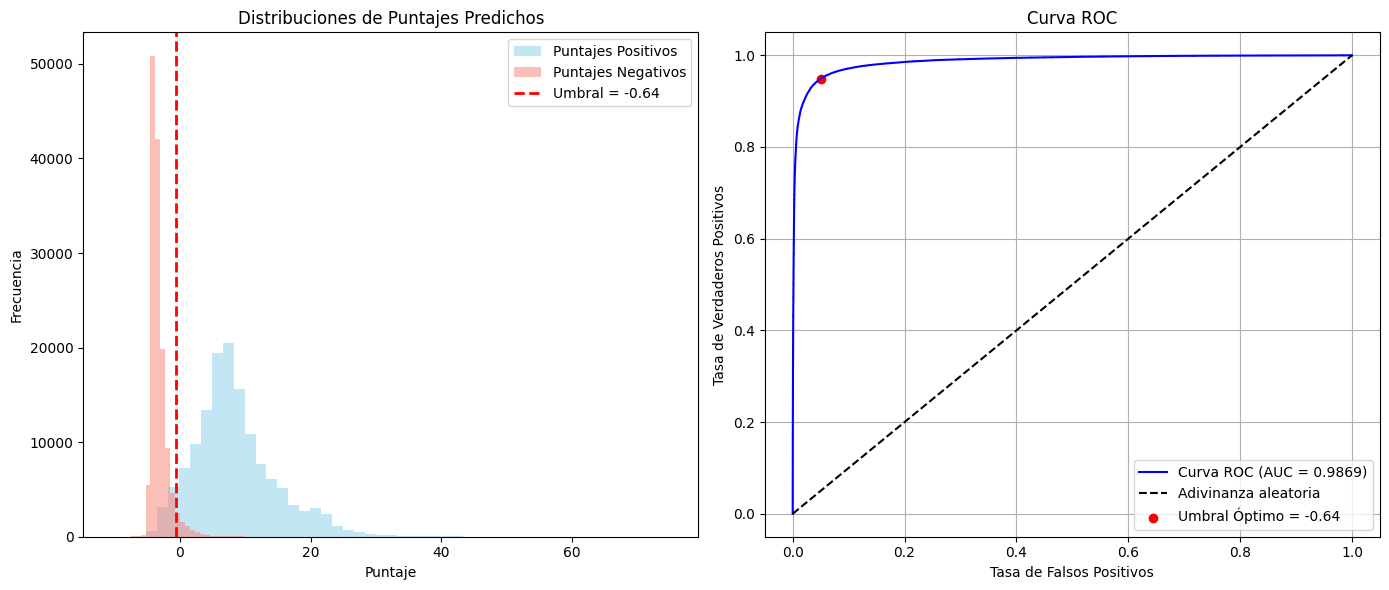

AUC: 0.9869
Optimal Threshold: -0.6409
Accuracy: 0.9495 (Threshold: -0.64)
Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, loss: 0.6944404244422913
In epoch 10, loss: 0.27919095754623413
In epoch 20, loss: 0.19460755586624146
In epoch 30, loss: 0.15860295295715332
In epoch 40, loss: 0.14286525547504425
In epoch 50, loss: 0.13397277891635895
In epoch 60, loss: 0.12734538316726685
In epoch 70, loss: 0.12194222211837769
In epoch 80, loss: 0.11804784834384918
In epoch 90, loss: 0.11513802409172058
AUC 0.9783100614569359


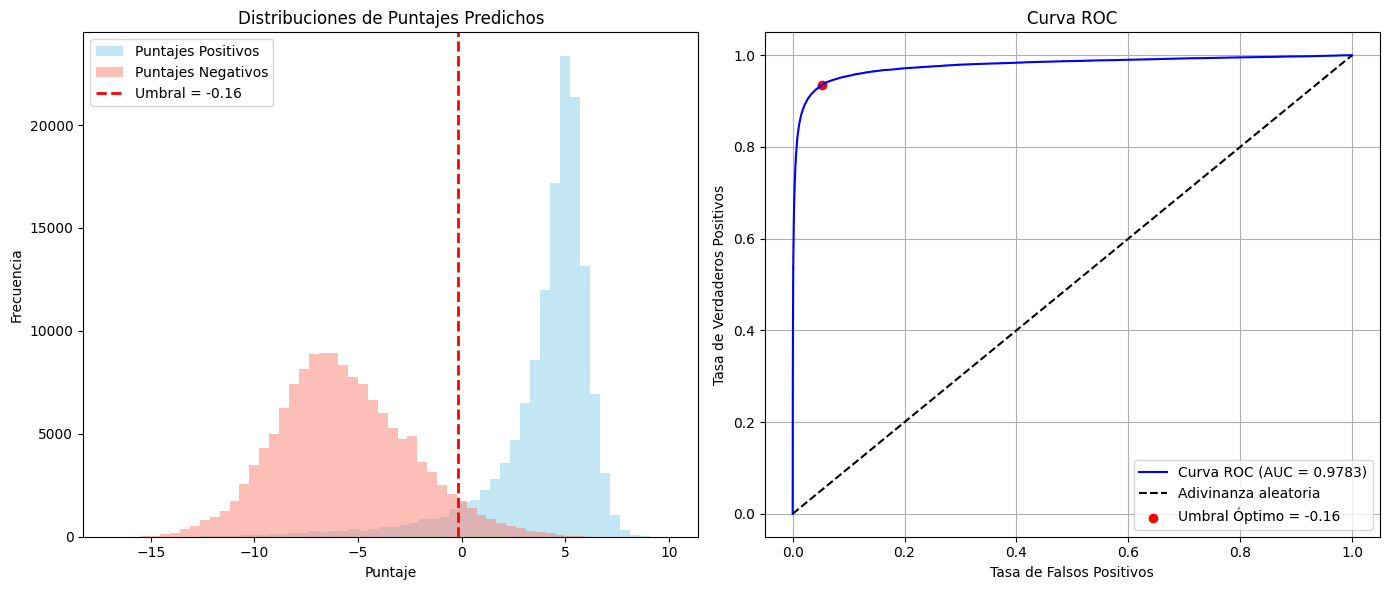

AUC: 0.9783
Optimal Threshold: -0.1581
Accuracy: 0.9416 (Threshold: -0.16)
Training model: GAT ----------------------------------------------- 

In epoch 0, loss: 0.7012609839439392
In epoch 10, loss: 0.4186464846134186
In epoch 20, loss: 0.3117847144603729
In epoch 30, loss: 0.26352909207344055
In epoch 40, loss: 0.21574804186820984
In epoch 50, loss: 0.20664578676223755
In epoch 60, loss: 0.20030303299427032
In epoch 70, loss: 0.19571316242218018
In epoch 80, loss: 0.1920619159936905
In epoch 90, loss: 0.1886618286371231
AUC 0.971912202181406


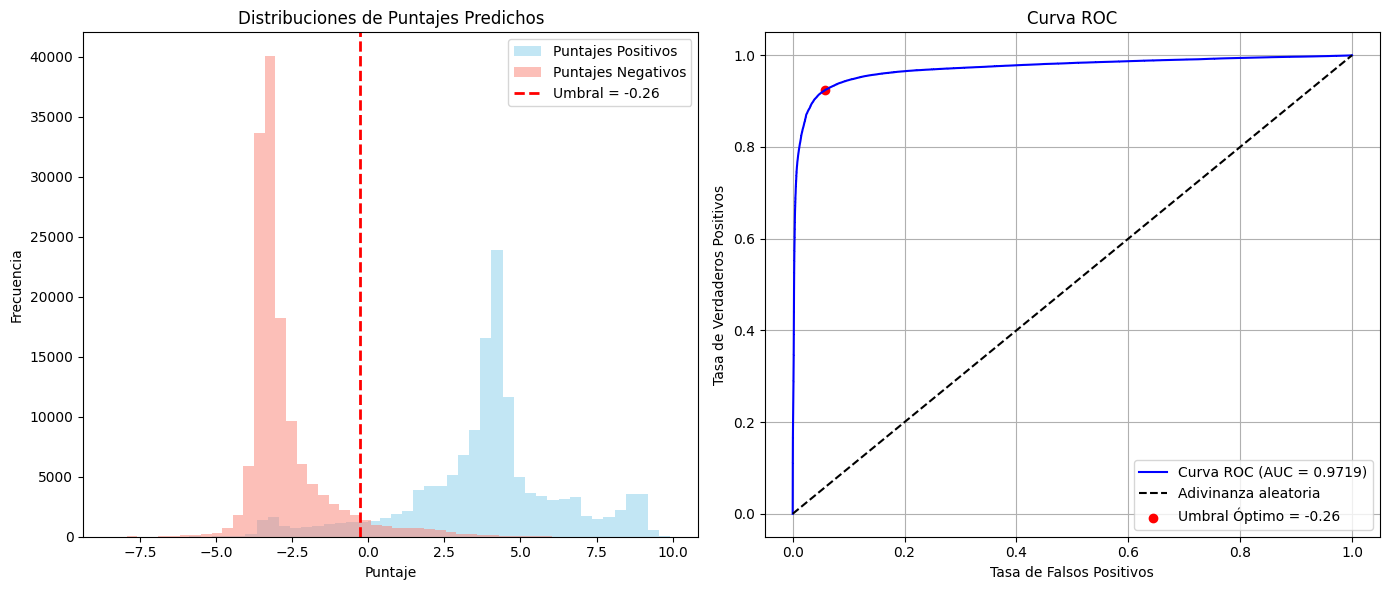

AUC: 0.9719
Optimal Threshold: -0.2605
Accuracy: 0.9331 (Threshold: -0.26)


In [10]:
decoder = 'MLP'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 16

for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # ----------- training -------------------------------- #

    all_logits = []
    for e in range(100):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeMLP(gnn.train_pos_g, h)
        neg_score = model.decodeMLP(gnn.train_neg_g, h)


        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("In epoch {}, loss: {}".format(e, loss))

    # ----------- check results ------------------------ #
    from sklearn.metrics import roc_auc_score

    with torch.no_grad():
        pos_score = model.decodeMLP(gnn.test_pos_g, h)
        neg_score = model.decodeMLP(gnn.test_neg_g, h)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr)
        compute_accuracy(pos_score, neg_score, threshold=threshold)
    # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}_{attr}.pth')
    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{decoder}_{model_name}_{attr}_febrero.pth')


    # Guardar los embeddings
    # torch.save(h, f"data/embeddings/embeddings_ribs_MLP_{model_name}_{attr}.pt")
    torch.save(h, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{decoder}_{model_name}_{attr}_febrero.pt")
    

In [ ]:
# Se incluyen los parametros tanto de MLP como de la GNN

for name, param in model.named_parameters():
    print(name, param.shape)


conv1.fc_neigh.weight torch.Size([16, 69])
conv1.fc_self.weight torch.Size([16, 69])
conv1.fc_self.bias torch.Size([16])
conv2.fc_neigh.weight torch.Size([16, 16])
conv2.fc_self.weight torch.Size([16, 16])
conv2.fc_self.bias torch.Size([16])
decoder.W1.weight torch.Size([16, 32])
decoder.W1.bias torch.Size([16])
decoder.W2.weight torch.Size([1, 16])
decoder.W2.bias torch.Size([1])


# 
De aqui en adelante pruebas desordenado!

# Crear Embeddings otros

## DeepWalk

In [3]:
from dgl.nn import DeepWalk
from torch.utils.data import DataLoader
from torch.optim import SparseAdam

In [15]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024/1millon

copia/  edges.csv*  graphs.csv*  meta.yaml*  nodes.csv*


In [4]:
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero/'
gnn = GNN(debug=True)
gnn.load_dataset(INTERNETGRAPH_FILE, force_reload=True,index_graph=1)
attr = 'deepWalk'
print('[ATTR SHAPE]: ',gnn.dgl_graph)
# in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
# gnn.split_graph_edges(0.8)
# gnn.split_graph_edges_basic(0.8)

[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 157675438})
[ATTR SHAPE]:  Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int8)})


DeepWalk:

* g (DGLGraph) – Graph for learning node embeddings
* emb_dim (int, optional) – Size of each embedding vector. Default: 128
* walk_length (int, optional) – Number of nodes in a random walk sequence. Default: 40
* window_size (int, optional) – In a random walk w, a node w[j] is considered close to a node w[i] if i - window_size <= j <= i + window_size. Default: 5
* neg_weight (float, optional) – Weight of the loss term for negative samples in the total loss. Default: 1.0
* negative_size (int, optional) – Number of negative samples to use for each positive sample. Default: 5
* fast_neg (bool, optional) – If True, it samples negative node pairs within a batch of random walks. Default: True
* sparse (bool, optional) – If True, gradients with respect to the learnable weights will be sparse. Default: True

In [5]:
model = DeepWalk(gnn.dgl_graph,
        emb_dim = 32,
        walk_length=40,
        window_size=1)

dataloader = DataLoader(torch.arange(gnn.dgl_graph.num_nodes()), batch_size=2,

                        shuffle=True, collate_fn=model.sample)


optimizer = SparseAdam(model.parameters(), lr=0.01)

num_epochs = 20

for batch_walk in dataloader:
    # batch_walk: (batch_size, walk_length)
    
    # Identificar cuáles filas NO tienen -1
    valid_mask = ~(batch_walk == -1).any(dim=1)
    
    # Filtrar filas válidas
    batch_walk_clean = batch_walk[valid_mask]
    
    # Si no hay caminatas válidas en el batch, continuar
    if batch_walk_clean.size(0) == 0:
        continue

    loss = model(batch_walk_clean)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [6]:
h = model.node_embed.weight.detach()
print("SHAPE",h.shape)
print("EMBEDDINGS",h)

SHAPE torch.Size([42683, 32])
EMBEDDINGS tensor([[ 0.0410,  0.3645,  0.2740,  ...,  0.3173,  0.4011, -0.1179],
        [ 0.0886,  0.6517, -0.1776,  ...,  0.4379,  0.3869, -0.0487],
        [ 0.3480, -0.2990,  0.4797,  ...,  0.2251,  0.1906, -0.4176],
        ...,
        [ 0.3131, -0.3339, -0.3356,  ...,  0.3705,  0.3713, -0.2985],
        [ 0.0842,  0.1637,  0.2372,  ...,  0.1910,  0.2431, -0.1965],
        [-0.0892, -0.0890,  0.5389,  ..., -0.0867,  0.3350, -0.4358]])


In [7]:
# Guardar los embeddings
# torch.save(h, "data/embeddings_deepWalk.pt")
torch.save(h, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_deepWalk_febrero.pt")

## PageRank

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

attr = 'pagerank'
# dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'
# dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

# dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/1millonfebrero'
# attr = 'grado_attr' 
dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024Degree/febrero'


In [9]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024Degree/febrero

edges.csv*  graphs.csv*  meta.yaml*  mini_multi_dataset/  nodes.csv*


In [11]:
# ---------------------- Cargar grafo ---------------------- #
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True,index_graph=1) # Febrero

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
gnn.split_graph_nodes(train_size=0.8)
print("Train mask:", 'train_mask' in gnn.dgl_graph.ndata)
print("Test mask:", 'test_mask' in gnn.dgl_graph.ndata)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 157675438})
[ATTR SHAPE]:  torch.Size([42683, 2])
Train nodes: 34146, Test nodes: 8537
Train mask: True
Test mask: True


In [12]:
# ---------------------- PageRank + Normalización ----------------------
N = gnn.dgl_graph.number_of_nodes()
DAMP = 0.85
K = 10


def compute_pagerank(g):
    g.ndata["pv"] = torch.ones(N) / N
    degrees = g.out_degrees(g.nodes()).type(torch.float32)
    for k in range(K):
        g.ndata["pv"] = g.ndata["pv"] / degrees
        g.update_all(
            message_func=fn.copy_u(u="pv", out="m"),
            reduce_func=fn.sum(msg="m", out="pv"),
        )
        g.ndata["pv"]  = (1 - DAMP) / N + DAMP * g.ndata["pv"]
    g.ndata["pv"]  = g.ndata["pv"].unsqueeze(1)
    return g.ndata["pv"]


# 1) Calcular PageRank original ----------------------------------------

pv = compute_pagerank(gnn.dgl_graph)
gnn.dgl_graph.ndata['pagerank'] = pv

# 2) Normalización min-max (GLOBAL) ------------------------------------
pr        = pv.squeeze()                    # (N,)
pr_min    = pr.min()
pr_max    = pr.max()
eps       = 1e-12                           # evita div/0
pr_mm     = (pr - pr_min) / (pr_max - pr_min + eps)
gnn.dgl_graph.ndata['pagerank'] = pr_mm.unsqueeze(1)


# 3) Normalización min-max SOLO con train ------------------------------
train_mask = gnn.dgl_graph.ndata['train_mask']
pr_train   = pr[train_mask]                 # vector de entrenamiento
pr_min_tr  = pr_train.min()
pr_max_tr  = pr_train.max()
pr_mm_tr   = (pr - pr_min_tr) / (pr_max_tr - pr_min_tr + eps)
gnn.dgl_graph.ndata['pagerank_minmax_tr'] = pr_mm_tr.unsqueeze(1)

In [13]:
# ---------------------- PageRank + Normalización (log + z) ----------------------
import torch
import dgl.function as fn

DAMP = 0.85
K    = 10
eps  = 1e-12                       # evita log(0)

N = gnn.dgl_graph.num_nodes()

def compute_pagerank(g, k=K, damp=DAMP):
    g = g.local_var()              # no ensucia atributos definitivos
    g.ndata['pv'] = torch.ones(N) / N
    deg = g.out_degrees(g.nodes()).float().clamp(min=1)
    for _ in range(k):
        g.ndata['pv'] = g.ndata['pv'] / deg
        g.update_all(fn.copy_u('pv', 'm'), fn.sum('m', 'pv'))
        g.ndata['pv'] = (1 - damp) / N + damp * g.ndata['pv']
    return g.ndata['pv'].unsqueeze(1)   # (N,1)

# 1) Calcular PageRank original ---------------------------------------
pv = compute_pagerank(gnn.dgl_graph)          # (N,1)
gnn.dgl_graph.ndata['pagerank_raw'] = pv      # guarda copia cruda

# 2) Transformación log10 ---------------------------------------------
pr_log = torch.log10(pv.squeeze() + eps)      # (N,)

# 3) Estadísticas SOLO en entrenamiento --------------------------------
train_mask = gnn.dgl_graph.ndata['train_mask']
mu  = pr_log[train_mask].mean()
std = pr_log[train_mask].std()

# 4) z-score -----------------------------------------------------------
pr_z = (pr_log - mu) / std                   # (N,)
gnn.dgl_graph.ndata['pagerank_norm'] = pr_z.unsqueeze(1)

print("PageRank normalizado (log+z) guardado en ndata['pagerank_norm']")


PageRank normalizado (log+z) guardado en ndata['pagerank_norm']


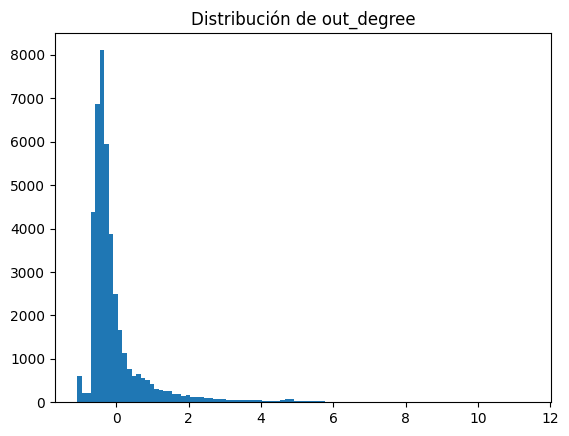

In [14]:
#  Distribución de PageRank normalizado
plt.hist(gnn.dgl_graph.ndata['pagerank_norm'].numpy(), bins=100)
plt.title("Distribución de out_degree")
plt.show()

In [15]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [1]:
features

NameError: name 'features' is not defined

In [16]:
features = gnn.dgl_graph.ndata['feat']

train_mask = gnn.dgl_graph.ndata['train_mask']
test_mask = gnn.dgl_graph.ndata['test_mask']

labels = gnn.dgl_graph.ndata['pagerank_norm']   # [N,1] shape


gnn.dgl_graph = dgl.add_self_loop(gnn.dgl_graph)

in_feats = features.shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1
epochs = 100

for model_name in models:

    print("\nTraining model: {} ----------------------------------------------- ".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # ----------- training -------------------------------- #
    train_losses = []
    test_losses = []

    # Para early stoping
    best_test_loss = float('inf')
    patience = 10  # Número de epochs que esperamos antes de parar
    patience_counter = 0


    for epoch in range(epochs):
        model.train()

        pred = model(gnn.dgl_graph, features)
        loss = loss_fn(pred[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluar
        model.eval()
        with torch.no_grad():
            pred_eval = model(gnn.dgl_graph, features)

            train_mse = loss_fn(pred_eval[train_mask], labels[train_mask]).item()
            test_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

            train_losses.append(train_mse)
            test_losses.append(test_mse)

        # Mostrar
        if epoch % 20 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train MSE = {train_mse:.6f}, Test MSE = {test_mse:.6f}")

        # ------------------ Early stopping check ------------------ #
        if test_mse < best_test_loss:
            best_test_loss = test_mse
            patience_counter = 0  # Resetea el contador
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test MSE: {best_test_loss:.6f}")
            break

    with torch.no_grad():
        embeddings = model.encode(gnn.dgl_graph, features)  # Shape: [num_nodes, out_feats]
        print(f"Embeddings shape: {embeddings.shape}")

    # torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{model_name}_{attr}_febrero.pth')
    torch.save(embeddings, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{model_name}_{attr}_febrero.pt")

    from sklearn.metrics import mean_absolute_error, r2_score

    # Obtener predicciones finales en test
    pred_test = pred_eval[test_mask].cpu().numpy().flatten()
    labels_test = labels[test_mask].cpu().numpy().flatten()

    # Calcular métricas
    final_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()
    mae = mean_absolute_error(labels_test, pred_test)
    r2 = r2_score(labels_test, pred_test)

    print(f"\n[Métricas finales para {model_name}]")
    print(f"Test MSE: {final_mse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"Test R²: {r2:.6f}")



    # --------- 4. Plotear evolución --------- #
    plt.plot(train_losses, label="Train MSE")
    plt.plot(test_losses, label="Test MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Evolución del error")
    plt.show()
    

    # Plot
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title(f"Evolución del error: {model_name}")
    plt.show()

    plt.scatter(labels_test, pred_test, alpha=0.2)
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"{model_name}: Real vs Predicho")
    plt.grid(True)
    plt.show()


Training model: GCN ----------------------------------------------- 


: 

Por Batches

In [14]:
# Crear Dataloader para batching
from dgl.dataloading import MultiLayerNeighborSampler,DataLoader, MultiLayerFullNeighborSampler


g = gnn.dgl_graph
features = g.ndata['feat']
labels = gnn.dgl_graph.ndata['pagerank_norm'].squeeze()   # (N,)


train_nid = torch.nonzero(gnn.dgl_graph.ndata['train_mask'], as_tuple=False).squeeze()
test_nid  = torch.nonzero(gnn.dgl_graph.ndata['test_mask'], as_tuple=False).squeeze()


sampler = MultiLayerFullNeighborSampler(2)  # ✅ Full neighbors, dos capas
train_loader = DataLoader(
    g, train_nid, sampler,
    batch_size=256,
    shuffle=True,
    drop_last=False,
    num_workers=0
)
test_loader = DataLoader(
    g, test_nid, sampler,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    num_workers=0
)




In [15]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler": GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler": GATSample
}


In [ ]:
in_feats = features.shape[1]
hidden_feats = 64
out_feats = 32
out_feats_mlp = 1
epochs = 100

for model_name in models:
    print(f"\nTraining model: {model_name} ----------------------------------------------- ")

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    )

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        n_train = 0

        for input_nodes, output_nodes, blocks in train_loader:
            x = features[input_nodes]
            y = labels[output_nodes]

            pred = model(blocks, x).squeeze()
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(output_nodes)
            n_train += len(output_nodes)

        train_mse = epoch_loss / n_train

        # ----------- Evaluación en test -------------------
        model.eval()
        test_loss = 0
        n_test = 0
        preds_test = []
        labels_test = []
        with torch.no_grad():
            for input_nodes, output_nodes, blocks in test_loader:
                x = features[input_nodes]
                y = labels[output_nodes]
                pred = model(blocks, x).squeeze()

                test_loss += loss_fn(pred, y).item() * len(output_nodes)
                n_test += len(output_nodes)
                preds_test.append(pred.cpu())
                labels_test.append(y.cpu())
        test_mse = test_loss / n_test

        train_losses.append(train_mse)
        test_losses.append(test_mse)

        if epoch % 20 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train MSE = {train_mse:.6f}, Test MSE = {test_mse:.6f}")

        # ----------- Early stopping ------------------
        if test_mse < best_test_loss:
            best_test_loss = test_mse
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test MSE: {best_test_loss:.6f}")
            break

    # --------- 3. Métricas finales -------------------
    from sklearn.metrics import mean_absolute_error, r2_score

    preds_test = torch.cat(preds_test).numpy().flatten()
    labels_test = torch.cat(labels_test).numpy().flatten()
    final_mse = loss_fn(torch.from_numpy(preds_test), torch.from_numpy(labels_test)).item()
    mae = mean_absolute_error(labels_test, preds_test)
    r2 = r2_score(labels_test, preds_test)

    print(f"\n[Métricas finales para {model_name}]")
    print(f"Test MSE: {final_mse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"Test R²: {r2:.6f}")

    model.eval()
    with torch.no_grad():
        embeddings = model.encode_full(gnn.dgl_graph, features).cpu()   # (N, out_feats)
        torch.save(embeddings, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{model_name}_{attr}_febrero.pt")

    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{model_name}_{attr}_febrero.pth')
    
    # --------- 4. Plotear evolución --------- #
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label="Train MSE")
    plt.plot(test_losses, label="Test MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Evolución del error")
    plt.show()


## Grado

In [ ]:
dataset_graph_path

In [2]:
import pandas as pd

path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

nodes = pd.read_csv(f'{path}/nodes.csv')
edges = pd.read_csv(f'{path}/edges.csv')

print("IDs presentes en nodos: ", sorted(nodes['graph_id'].unique()))
print("IDs presentes en aristas: ", sorted(edges['graph_id'].unique()))

missing = set(nodes['graph_id'].unique()) - set(edges['graph_id'].unique())
print("Graph IDs sin aristas: ", missing)


IDs presentes en nodos:  [2]
IDs presentes en aristas:  [2]
Graph IDs sin aristas:  set()


In [6]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024/1millon

copia/  edges.csv*  graphs.csv*  meta.yaml*  nodes.csv*


In [ ]:
dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'
dgl_graph = dgl.data.CSVDataset(dataset_graph_path, force_reload=True)

In [3]:
attr = 'out_degree'

# / ---------------------- Cargar grafo ---------------------- #
# dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

dataset_graph_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/1millonfebrero'
gnn = GNN(debug=True)
# gnn.load_dataset(dataset_graph_path, force_reload=True,index_graph=1) # Febrero
gnn.load_dataset(dataset_graph_path, force_reload=True,index_graph=1)

# print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
gnn.split_graph_nodes(train_size=0.8)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42476, num_edges=33239820,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 33239820})
Train nodes: 33980, Test nodes: 8496


In [4]:
degrees = gnn.dgl_graph.out_degrees(gnn.dgl_graph.nodes()).float().unsqueeze(1)

# Transformación logarítmica
deg_log = torch.log1p(degrees)  # log(1 + x)

# Min-max normalization después del log
min_val = deg_log.min()
max_val = deg_log.max()
deg_log_norm = (deg_log - min_val) / (max_val - min_val + 1e-8)

gnn.dgl_graph.ndata['out_degree'] = deg_log_norm


In [5]:
models = {
    # 'GCN': GCN,
    # 'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

Inspecciona la distribución de out_degree:

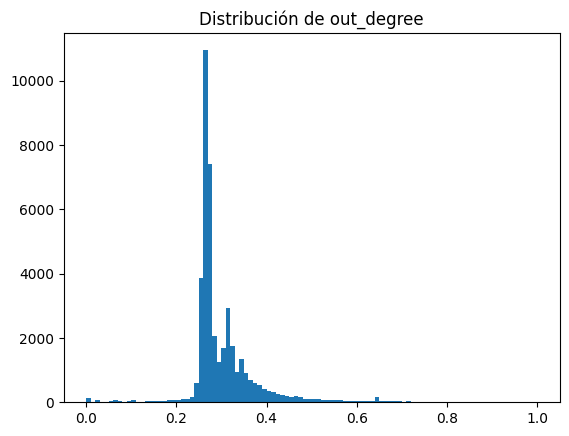

In [ ]:
# Inspecciona la distribución de out_degree:

plt.hist(deg_log_norm.numpy(), bins=100)
plt.title("Distribución de out_degree")
plt.show()


Calcula la varianza de los labels:

In [10]:
import numpy as np
print("Varianza de labels de test:", np.var(labels[test_mask].cpu().numpy()))


NameError: name 'labels' is not defined


Training model: GAT ----------------------------------------------- 
Epoch 0: Train MSE = 0.071787, Test MSE = 0.071713
Epoch 20: Train MSE = 0.052356, Test MSE = 0.052922
Epoch 39: Train MSE = 0.048278, Test MSE = 0.048624
Embeddings shape: torch.Size([42476, 32])

[Métricas finales para GAT]
Test MSE: 0.048624
Test MAE: 0.048624
Test R²: -0.055724


/tmp/ipykernel_9761/3942833178.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


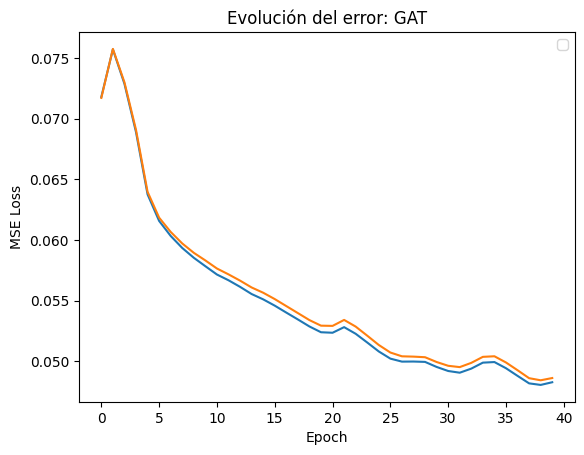

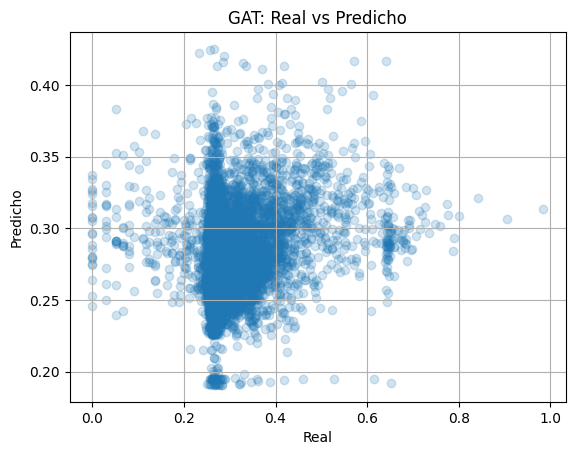

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score

attr = 'out_degree'


features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.ndata[attr]

train_mask = gnn.dgl_graph.ndata['train_mask']
test_mask = gnn.dgl_graph.ndata['test_mask']


in_feats = features.shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1
lr = 0.001
epochs = 40


for model_name in models:

    print("\nTraining model: {} ----------------------------------------------- ".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
        
    
    # loKss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()        # MAE
    # loss_fn = nn.SmoothL1Loss()  # Huber

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        model.train()

        pred = model(gnn.dgl_graph, features)
        loss = loss_fn(pred[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            pred_eval = model(gnn.dgl_graph, features)

            train_mse = loss_fn(pred_eval[train_mask], labels[train_mask]).item()
            test_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

            train_losses.append(train_mse)
            test_losses.append(test_mse)

        if epoch % 20 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train MSE = {train_mse:.6f}, Test MSE = {test_mse:.6f}")

        if test_mse < best_test_loss:
            best_test_loss = test_mse
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test MSE: {best_test_loss:.6f}")
            break

    with torch.no_grad():
        embeddings = model.encode(gnn.dgl_graph, features)
        print(f"Embeddings shape: {embeddings.shape}")

    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{model_name}_{attr}_febrero.pth')
    torch.save(embeddings, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{model_name}_{attr}_febrero.pt")

    # Métricas finales
    pred_test = pred_eval[test_mask].cpu().numpy().flatten()
    labels_test = labels[test_mask].cpu().numpy().flatten()

    final_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

    mae = mean_absolute_error(labels_test, pred_test)
    r2 = r2_score(labels_test, pred_test)

    print(f"\n[Métricas finales para {model_name}]")
    print(f"Test MSE: {final_mse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"Test R²: {r2:.6f}")

    # Plot
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title(f"Evolución del error: {model_name}")
    plt.show()

    plt.scatter(labels_test, pred_test, alpha=0.2)
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"{model_name}: Real vs Predicho")
    plt.grid(True)
    plt.show()



con batches

In [9]:
# Crear Dataloader para batching
from dgl.dataloading import MultiLayerNeighborSampler,DataLoader, MultiLayerFullNeighborSampler


g = gnn.dgl_graph
features = g.ndata['feat']
labels = gnn.dgl_graph.ndata['out_degree'].squeeze()   # (N,)


train_nid = torch.nonzero(gnn.dgl_graph.ndata['train_mask'], as_tuple=False).squeeze()
test_nid  = torch.nonzero(gnn.dgl_graph.ndata['test_mask'], as_tuple=False).squeeze()


sampler = MultiLayerFullNeighborSampler(2)  # ✅ Full neighbors, dos capas
train_loader = DataLoader(
    g, train_nid, sampler,
    batch_size=256,
    shuffle=True,
    drop_last=False,
    num_workers=0
)
test_loader = DataLoader(
    g, test_nid, sampler,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    num_workers=0
)




In [10]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler": GCNSampler,
    # "GraphSAGE-Sampler": GraphSAGESample,
    # "SAGE-Sampler": GraphSAGESample,
}

In [11]:
in_feats = features.shape[1]
hidden_feats = 64
out_feats = 32
out_feats_mlp = 1

for model_name in models:
    print(f"\nTraining model: {model_name} ----------------------------------------------- ")

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    )

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epochs = 100
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        n_train = 0

        for input_nodes, output_nodes, blocks in train_loader:
            x = features[input_nodes]
            y = labels[output_nodes]

            pred = model(blocks, x)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(output_nodes)
            n_train += len(output_nodes)

        train_mse = epoch_loss / n_train

        # ----------- Evaluación en test -------------------
        model.eval()
        test_loss = 0
        n_test = 0
        preds_test = []
        labels_test = []
        with torch.no_grad():
            for input_nodes, output_nodes, blocks in test_loader:
                x = features[input_nodes]
                y = labels[output_nodes]
                pred = model(blocks, x).squeeze()

                test_loss += loss_fn(pred, y).item() * len(output_nodes)
                n_test += len(output_nodes)
                preds_test.append(pred.cpu())
                labels_test.append(y.cpu())
        test_mse = test_loss / n_test

        train_losses.append(train_mse)
        test_losses.append(test_mse)

        if epoch % 20 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train MSE = {train_mse:.6f}, Test MSE = {test_mse:.6f}")

        # ----------- Early stopping ------------------
        if test_mse < best_test_loss:
            best_test_loss = test_mse
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test MSE: {best_test_loss:.6f}")
            break

    # --------- 3. Métricas finales -------------------
    from sklearn.metrics import mean_absolute_error, r2_score

    preds_test = torch.cat(preds_test).numpy().flatten()
    labels_test = torch.cat(labels_test).numpy().flatten()
    final_mse = loss_fn(torch.from_numpy(preds_test), torch.from_numpy(labels_test)).item()
    mae = mean_absolute_error(labels_test, preds_test)
    r2 = r2_score(labels_test, preds_test)

    print(f"\n[Métricas finales para {model_name}]")
    print(f"Test MSE: {final_mse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"Test R²: {r2:.6f}")

    model.eval()
    with torch.no_grad():
        embeddings = model.encode_full(gnn.dgl_graph, features).cpu()   # (N, out_feats)
        torch.save(embeddings, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{model_name}_{attr}_febrero.pt")

    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{model_name}_{attr}_febrero.pth')
    
    # --------- 4. Plotear evolución --------- #
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label="Train MSE")
    plt.plot(test_losses, label="Test MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Evolución del error")
    plt.show()



Training model: GCN-Sampler ----------------------------------------------- 


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (32) must match the size of tensor b (256) at non-singleton dimension 1

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(labels_test, pred_test, alpha=0.2)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("GCN: Real vs Predicho")
plt.grid(True)
plt.show()

## Closeness

In [5]:
import networkx as nx

In [6]:
# ---------------------- Cargar grafo ---------------------- #
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True,index_graph=1) # Febrero

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
gnn.split_graph_nodes(train_size=0.8)



Done saving data into cached files.
Graph(num_nodes=42242, num_edges=6648566,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[ATTR SHAPE]:  torch.Size([42242, 68])
Train nodes: 33793, Test nodes: 8449


In [7]:
# Convertir a NetworkX y a no dirigido
nx_g = gnn.dgl_graph.to_networkx().to_undirected()

# Calcular closeness
closeness_dict = nx.closeness_centrality(nx_g)

# Convertir a lista ordenada
num_nodes = gnn.dgl_graph.number_of_nodes()
closeness_list = [closeness_dict[i] for i in range(num_nodes)]
closeness_tensor = torch.tensor(closeness_list, dtype=torch.float32).unsqueeze(1)

# Guardar en el grafo
gnn.dgl_graph.ndata['closeness'] = closeness_tensor

# Definir atributo
attr = 'closeness'
labels = gnn.dgl_graph.ndata[attr]


In [ ]:
features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.ndata[attr]

train_mask = gnn.dgl_graph.ndata['train_mask']
test_mask = gnn.dgl_graph.ndata['test_mask']

gnn.dgl_graph = dgl.add_self_loop(gnn.dgl_graph)

in_feats = features.shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

for model_name in models:

    print("\nTraining model: {} ----------------------------------------------- ".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epochs = 100
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        model.train()

        pred = model(gnn.dgl_graph, features)
        loss = loss_fn(pred[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            pred_eval = model(gnn.dgl_graph, features)

            train_mse = loss_fn(pred_eval[train_mask], labels[train_mask]).item()
            test_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

            train_losses.append(train_mse)
            test_losses.append(test_mse)

        if epoch % 20 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train MSE = {train_mse:.6f}, Test MSE = {test_mse:.6f}")

        if test_mse < best_test_loss:
            best_test_loss = test_mse
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test MSE: {best_test_loss:.6f}")
            break

    with torch.no_grad():
        embeddings = model.encode(gnn.dgl_graph, features)
        print(f"Embeddings shape: {embeddings.shape}")

    torch.save(model.state_dict(), '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f'/model_emb_{model_name}_{attr}_febrero.pth')
    torch.save(embeddings, '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024' + f"/embeddings_ribs_{model_name}_{attr}_febrero.pt")

    # Métricas finales
    pred_test = pred_eval[test_mask].cpu().numpy().flatten()
    labels_test = labels[test_mask].cpu().numpy().flatten()

    final_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()
    mae = mean_absolute_error(labels_test, pred_test)
    r2 = r2_score(labels_test, pred_test)

    print(f"\n[Métricas finales para {model_name}]")
    print(f"Test MSE: {final_mse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"Test R²: {r2:.6f}")

    # Plot
    plt.plot(train_losses, label="Train MSE")
    plt.plot(test_losses, label="Test MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title(f"Evolución del error: {model_name}")
    plt.show()